<a href="https://colab.research.google.com/github/Azadshokrollahi/Advance-machine-learning/blob/develop/0-basics_intro/1_datasets_dataloaders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Grayscale, Compose, Resize
import matplotlib.pyplot as plt

We load the FashionMNIST Dataset with the following parameters:
    
- root is the path where the train/test data is stored,
- train specifies training or test dataset,
- download=True downloads the data from the internet if it’s not available at root.
- transform and target_transform specify the feature and label transformations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Change root dir to wherever your data is!
root_dir = '/content/drive/MyDrive/Work/PHD/courses-AML/data_aml'
data_path = "/content/data"
!unzip "/content/drive/MyDrive/Work/PHD/courses-AML/data_aml/FashionMNIST.zip" -d $data_path

training_data = datasets.FashionMNIST(
    root=data_path,
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root=data_path,
    train=False,
    download=True,
    transform=ToTensor()
)

Archive:  /content/drive/MyDrive/Work/PHD/courses-AML/data_aml/FashionMNIST.zip
   creating: /content/data/FashionMNIST/
  inflating: /content/data/FashionMNIST/.DS_Store  
  inflating: /content/data/__MACOSX/FashionMNIST/._.DS_Store  
   creating: /content/data/FashionMNIST/processed/
   creating: /content/data/FashionMNIST/raw/
  inflating: /content/data/FashionMNIST/processed/training.pt  
  inflating: /content/data/FashionMNIST/processed/test.pt  
  inflating: /content/data/FashionMNIST/raw/t10k-images-idx3-ubyte  
  inflating: /content/data/FashionMNIST/raw/t10k-labels-idx1-ubyte  
  inflating: /content/data/FashionMNIST/raw/train-images-idx3-ubyte  
  inflating: /content/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz  
  inflating: /content/data/FashionMNIST/raw/train-images-idx3-ubyte.gz  
  inflating: /content/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz  
  inflating: /content/data/FashionMNIST/raw/train-labels-idx1-ubyte  
  inflating: /content/data/FashionMNIST/raw/t10k

## Iterating datastes ##

We can index Datasets manually like a list: training_data[index]. We use matplotlib to visualize some samples in our training data.

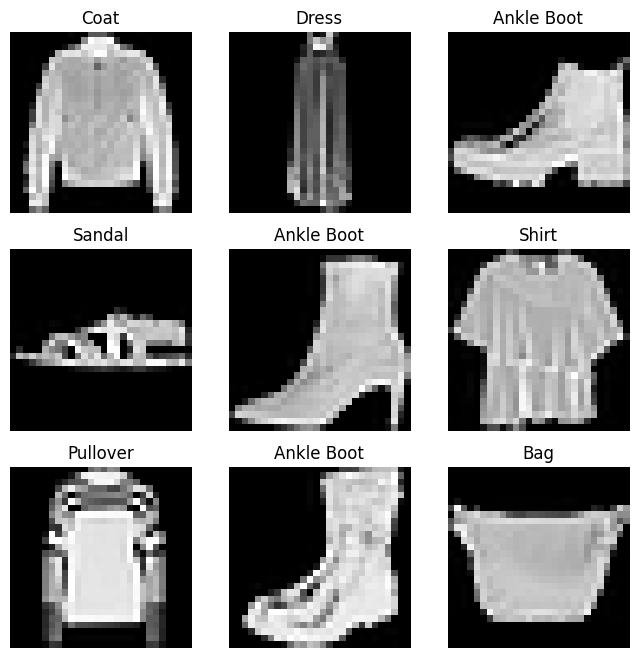

In [ ]:
# We use this dictionary to connect the indices to string
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item() # Get rnd_id
    img, label = training_data[sample_idx] # index dataset (gets you the img and label - index)
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Creating a Custom Dataset for your files ##
A custom Dataset class must implement three functions: __init__, __len__, and __getitem__. Take a look at this implementation; the FashionMNIST images are stored in a directory img_dir, and their labels are stored separately in a CSV file annotations_file.

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path) # Converts to tensor
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = {"image": image, "label": label}
        return sample

## Preparing your data for training with DataLoaders ##
The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


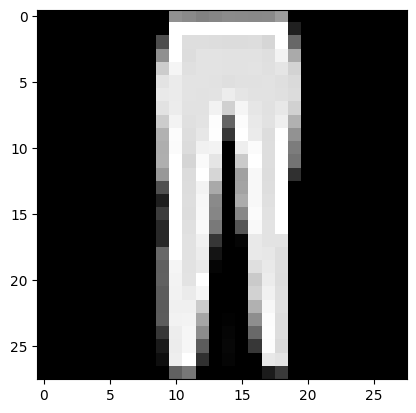

Label: 1


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
# [64, 1, 28, 28] -- 64 batch size, 1 channels, 28 width, 28 height
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## TRANSFORMS ##
Data does not always come in its final processed form that is required for training machine learning algorithms. We use transforms to perform some manipulation of the data and make it suitable for training.

All TorchVision datasets have two parameters -__transform__ to modify the features and __target_transform__ to modify the labels - that accept callables containing the transformation logic. The torchvision.transforms module offers several commonly-used transforms out of the box.

The FashionMNIST features are in PIL Image format, and the labels are integers. For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors. To make these transformations, we use ToTensor and Lambda.

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root=data_path,
    train=True,
    download=True,
    transform=ToTensor(), # Converts the image to a tensor
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)


#Lambda transforms apply any user-defined lambda function. Here, we define a function to turn the integer into a one-hot encoded tensor.
# It first creates a zero tensor of size 10 (the number of labels in our dataset) and
# calls scatter_ which assigns a value=1 on the index as given by the label y.